In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from procgen import ProcgenEnv
import struct
from dataclasses import dataclass
import typing
from einops import rearrange

In [3]:

# Parse the environment state dict

MAZE_STATE_DICT_TEMPLATE = [
    ['int',    'SERIALIZE_VERSION'],
    ['string', 'game_name'],
    ['int',    'options.paint_vel_info'],
    ['int',    'options.use_generated_assets'],
    ['int',    'options.use_monochrome_assets'],
    ['int',    'options.restrict_themes'],
    ['int',    'options.use_backgrounds'],
    ['int',    'options.center_agent'],
    ['int',    'options.debug_mode'],
    ['int',    'options.distribution_mode'],
    ['int',    'options.use_sequential_levels'],
    ['int',    'options.use_easy_jump'],
    ['int',    'options.plain_assets'],
    ['int',    'options.physics_mode'],
    ['int',    'grid_step'],
    ['int',    'level_seed_low'],
    ['int',    'level_seed_high'],
    ['int',    'game_type'],
    ['int',    'game_n'],
    # level_seed_rand_gen.serialize(b'],
    ['int',    'level_seed_rand_gen.is_seeded'],
    ['string', 'level_seed_rand_gen.str'],
    # end level_seed_rand_gen.serialize(b'],
    # rand_gen.serialize(b'],
    ['int',    'rand_gen.is_seeded'],
    ['string', 'rand_gen.str'],
    # end rand_gen.serialize(b'],
    ['float',  'step_data.reward'],
    ['int',    'step_data.done'],
    ['int',    'step_data.level_complete'],
    ['int',    'action'],
    ['int',    'timeout'],
    ['int',    'current_level_seed'],
    ['int',    'prev_level_seed'],
    ['int',    'episodes_remaining'],
    ['int',    'episode_done'],
    ['int',    'last_reward_timer'],
    ['float',  'last_reward'],
    ['int',    'default_action'],
    ['int',    'fixed_asset_seed'],
    ['int',    'cur_time'],
    ['int',    'is_waiting_for_step'],
    # end Game::serialize(b'],
    ['int',    'grid_size'],
    # write_entities(b, entities'],
    ['int',    'ents.size'],
    #for (size_t i = 0; i < ents.size(', i++)
    ['loop',   'ents', 'ents.size', [
        # ents[i]->serialize(b'],
        ['float',  'x'],
        ['float',  'y'],
        ['float',  'vx'],
        ['float',  'vy'],
        ['float',  'rx'],
        ['float',  'ry'],
        ['int',    'type'],
        ['int',    'image_type'],
        ['int',    'image_theme'],
        ['int',    'render_z'],
        ['int',    'will_erase'],
        ['int',    'collides_with_entities'],
        ['float',  'collision_margin'],
        ['float',  'rotation'],
        ['float',  'vrot'],
        ['int',    'is_reflected'],
        ['int',    'fire_time'],
        ['int',    'spawn_time'],
        ['int',    'life_time'],
        ['int',    'expire_time'],
        ['int',    'use_abs_coords'],
        ['float',  'friction'],
        ['int',    'smart_step'],
        ['int',    'avoids_collisions'],
        ['int',    'auto_erase'],
        ['float',  'alpha'],
        ['float',  'health'],
        ['float',  'theta'],
        ['float',  'grow_rate'],
        ['float',  'alpha_decay'],
        ['float',  'climber_spawn_x',]]],
    # end ents[i]->serialize(b'],
    # end write_entities
    ['int',    'use_procgen_background'],
    ['int',    'background_index'],
    ['float',  'bg_tile_ratio'],
    ['float',  'bg_pct_x'],
    ['float',  'char_dim'],
    ['int',    'last_move_action'],
    ['int',    'move_action'],
    ['int',    'special_action'],
    ['float',  'mixrate'],
    ['float',  'maxspeed'],
    ['float',  'max_jump'],
    ['float',  'action_vx'],
    ['float',  'action_vy'],
    ['float',  'action_vrot'],
    ['float',  'center_x'],
    ['float',  'center_y'],
    ['int',    'random_agent_start'],
    ['int',    'has_useful_vel_info'],
    ['int',    'step_rand_int'],
    # asset_rand_gen.serialize(b'],
    ['int',    'asset_rand_gen.is_seeded'],
    ['string', 'asset_rand_gen.str'],
    # end asset_rand_gen.serialize(b'],
    ['int',    'main_width'],
    ['int',    'main_height'],
    ['int',    'out_of_bounds_object'],
    ['float',  'unit'],
    ['float',  'view_dim'],
    ['float',  'x_off'],
    ['float',  'y_off'],
    ['float',  'visibility'],
    ['float',  'min_visibility'],
    # grid.serialize(b'],
    ['int',    'w'],
    ['int',    'h'],
    # b->write_vector_int(data'],
    ['int',    'data.size'],
    # for (auto i : v) {
    ['loop',   'data', 'data.size', [['int',    'i']]],
    # end b->write_vector_int(data'],
    # end grid.serialize(b'],
    # end BasicAbstractGame::serialize(b'],
    ['int',    'maze_dim'],
    ['int',    'world_dim'], 
    ['int',    'END_OF_BUFFER']]

@dataclass
class StateValue:
    val: typing.Any
    idx: int

def parse_maze_state_bytes(state_bytes):
    # Functions to read values of different types
    def read_fixed(sb, idx, fmt):
        sz = struct.calcsize(fmt)
        # print(f'{idx} chomp {sz} got {len(sb[idx:(idx+sz)])} fmt {fmt}')
        val = struct.unpack(fmt, sb[idx:(idx+sz)])[0]
        idx += sz
        return val, idx
    read_int = lambda sb, idx: read_fixed(sb, idx, '@i')
    read_float = lambda sb, idx: read_fixed(sb, idx, '@f')
    def read_string(sb, idx):
        sz, idx = read_int(sb, idx)
        val = sb[idx:(idx+sz)].decode('ascii')
        idx += sz
        return val, idx
    
    # Function to process a value definition and return a value (called recursively for loops)
    def parse_value(vals, val_def, idx):
        typ = val_def[0]
        name = val_def[1]
        # print((typ, name))
        if typ == 'int':
            val, idx = read_int(state_bytes, idx)
            vals[name] = StateValue(val, idx)
        elif typ == 'float':
            val, idx = read_float(state_bytes, idx)
            vals[name] = StateValue(val, idx)
        elif typ == 'string':
            val, idx = read_string(state_bytes, idx)
            vals[name] = StateValue(val, idx)
        elif typ == 'loop':
            len_name = val_def[2]
            loop_val_defs = val_def[3]
            loop_len = vals[len_name].val
            vals[name] = []
            for ii in range(loop_len):
                vals_this = {}
                for loop_val_def in loop_val_defs:
                    idx = parse_value(vals_this, loop_val_def, idx)
                vals[name].append(vals_this)
        return idx
    
    # Dict to hold values
    vals = {}
    
    # Loop over list of value defs, parsing each
    idx = 0
    for val_def in MAZE_STATE_DICT_TEMPLATE:
        idx = parse_value(vals, val_def, idx)

    return vals

def serialize_maze_state(state_vals):
    # Serialize any value to a bytes object
    def serialize_val(val):
        if isinstance(val, StateValue):
            val = val.val
        if isinstance(val, int):
            return struct.pack('@i', val)
        elif isinstance(val, float):
            return struct.pack('@f', val)
        elif isinstance(val, str):
            return serialize_val(len(val)) + val.encode('ascii')
 
    # Flatten the nested values into a single list of primitives
    def flatten_vals(vals, flat_list=[]):
        if isinstance(vals, dict):
            for val in vals.values():
                flatten_vals(val, flat_list)
        elif isinstance(vals, list):
            for val in vals:
                flatten_vals(val, flat_list)
        else:
            flat_list.append(vals)
    
    # Flatten the values, then serialize
    flat_vals = []
    flatten_vals(state_vals, flat_vals)
    return b''.join([serialize_val(val) for val in flat_vals])
    #return sum([serialize_val(val) for val in flat_vals])
    #return serialize_val(state_vals)



In [4]:
from procgen import ProcgenGym3Env
from common.env.procgen_wrappers import TransposeFrame, ScaledFloatFrame, VecExtractDictObs
from gym3 import ViewerWrapper, VideoRecorderWrapper, ToBaselinesVecEnv

# same wrapper used for agent
def create_venv_render():
    venv = ProcgenGym3Env(
        num=1, env_name='maze', num_levels=0, start_level=0,
        distribution_mode='hard', num_threads=1, render_mode="rgb_array",
    )
    venv = ToBaselinesVecEnv(venv) # gym3 env to gym env converter
    venv = VecExtractDictObs(venv, "rgb")

    venv = TransposeFrame(venv)
    venv = ScaledFloatFrame(venv)
    return venv


building procgen...done


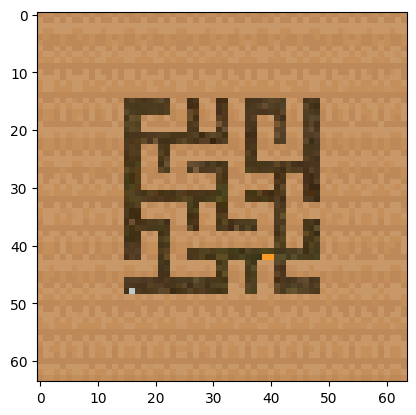

In [5]:
# Make env the gym3 way
# venv = ProcgenEnv(num_envs=1, env_name='maze', num_levels=0, start_level=0)
venv = create_venv_render()
obs = venv.reset()
plt.imshow(obs[0].transpose(1,2,0))

In [6]:
# Get the serialized state
state_bytes = venv.env.callmethod("get_state")[0]
state_vals = parse_maze_state_bytes(state_bytes)

# Test that serialize(deserialize(x)) = x
assert state_bytes == serialize_maze_state(state_vals)

In [7]:
state_vals['world_dim']

StateValue(val=25, idx=23024)

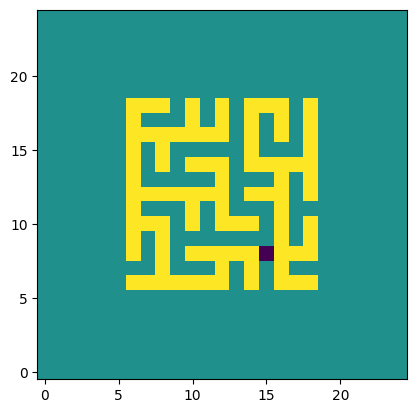

In [8]:
# Show that we can get the maze state (walls, cheese, etc.)
#grid_vals = rearrange(np.array([dd['i'].val for dd in state_vals['data']]), '(h w) -> h w', 
#    h=state_vals['world_dim'].val)

world_dim = state_vals['world_dim'].val
grid_vals = np.array([dd['i'].val for dd in state_vals['data']]).reshape(world_dim, world_dim)
plt.imshow(grid_vals, origin='lower')

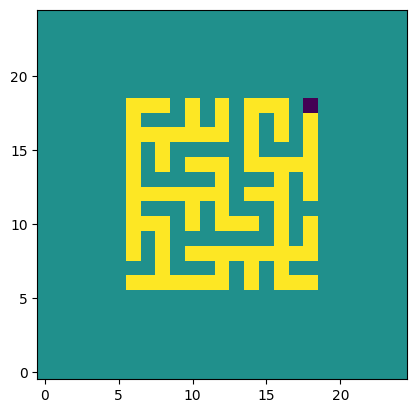

In [9]:
# Get the cheese position
GRID_VAL_CHEESE = 2
GRID_VAL_OPEN = 100
curr_cheese_row, curr_cheese_col = [a[0] for a in np.nonzero(grid_vals==GRID_VAL_CHEESE)] # We know there will only be one element in these index arrays
# equiv to (25*curr_cheese_row + curr_cheese_col) in this case
curr_cheese_idx = np.ravel_multi_index((curr_cheese_row, curr_cheese_col), grid_vals.shape)

# Get rid of existing cheese
state_vals['data'][curr_cheese_idx]['i'].val = GRID_VAL_OPEN

# Move the cheese to the top right corner (highest top right open square)
htr = [i for i in range(len(grid_vals)) if grid_vals[i, i] == GRID_VAL_OPEN][-1]
new_cheese_idx = np.ravel_multi_index((htr, htr), grid_vals.shape)
assert state_vals['data'][new_cheese_idx]['i'].val == GRID_VAL_OPEN, f'cheese cant go there'
state_vals['data'][new_cheese_idx]['i'].val = GRID_VAL_CHEESE

# plot the new grid
grid_vals = rearrange(np.array([dd['i'].val for dd in state_vals['data']]), '(h w) -> h w', 
    h=state_vals['world_dim'].val)
plt.imshow(grid_vals, origin='lower')

In [10]:
# Re-serialize the modified states
state_bytes_mod = serialize_maze_state(state_vals)


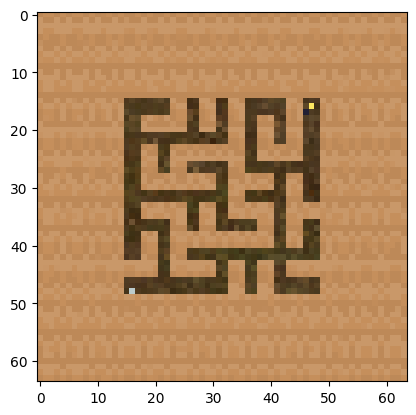

In [11]:
# Try loading a new env, then loading the modified state, see if it all works
venv = create_venv_render()
venv.env.callmethod("set_state", [state_bytes_mod])
obs = venv.reset()
plt.imshow(obs[0].transpose(1,2,0))

# Run agent on the maze

In [12]:
import torch

In [13]:
checkpoint = torch.load('./model_200015872.pth', map_location=torch.device('cpu'))

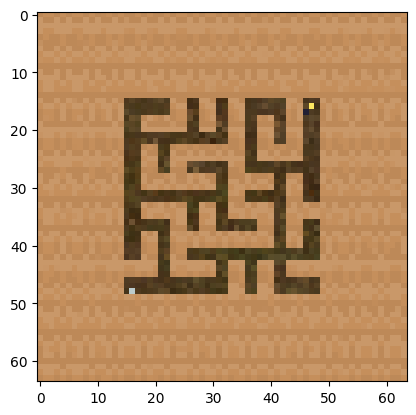

In [14]:
obs = venv.reset()
plt.imshow(obs[0].transpose(1,2,0))

In [15]:
import yaml
param_name = 'easy-200' # default in argparse
with open('hyperparams/procgen/config.yml', 'r') as f:
    hyperparameters = yaml.safe_load(f)[param_name]
for key, value in hyperparameters.items():
    print(key, ':', value)


algo : ppo
n_envs : 128
n_steps : 256
epoch : 3
mini_batch_per_epoch : 8
mini_batch_size : 2048
gamma : 0.999
lmbda : 0.95
learning_rate : 0.0005
grad_clip_norm : 0.5
eps_clip : 0.2
value_coef : 0.5
entropy_coef : 0.01
normalize_adv : True
normalize_rew : True
use_gae : True
architecture : impala
recurrent : False


In [16]:
from common.logger import Logger
from common.storage import Storage
from common.model import NatureModel, ImpalaModel
from common.policy import CategoricalPolicy
from agents.ppo import PPO

In [23]:
hyperparameters['n_envs'] = 1
logdir = None
observation_space = venv.observation_space
observation_shape = observation_space.shape
in_channels = observation_shape[0]
assert in_channels == 3, f'obs.shape[0]={observation_shape[0]} is not 3 (rgb) '
n_steps = hyperparameters['n_steps']
recurrent = hyperparameters['recurrent']
device = torch.device('cpu')

logger = Logger(n_envs, logdir)


model = ImpalaModel(in_channels=in_channels)
hidden_state_dim = model.output_dim
policy = CategoricalPolicy(model, recurrent, action_size=venv.action_space.n)

storage = Storage(observation_shape, hidden_state_dim, n_steps, n_envs, device)


agent = PPO(venv, policy, logger, storage, device, n_checkpoints=1, **hyperparameters)
agent.policy.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [24]:
from IPython import display


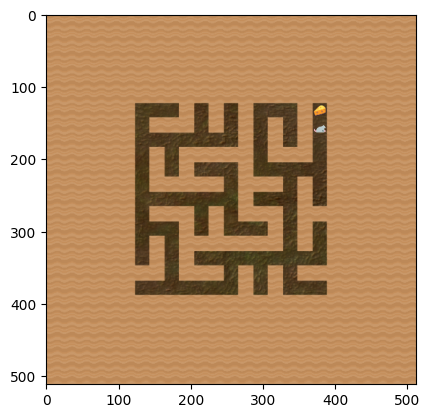

In [32]:
# set the agent env to be the serialized venv from earlier
agent.env.env.callmethod("set_state", [state_bytes_mod])
obs = agent.env.reset()

hidden_state = np.zeros((agent.n_envs, agent.storage.hidden_state_size))
done = np.zeros(agent.n_envs)

while not all(done):
    agent.policy.eval()
    act, log_prob_act, value, next_hidden_state = agent.predict(obs, hidden_state, done)
    next_obs, rew, done, info = agent.env.step(act)

    if not all(done): # don't show last frame (new maze)
        # plt.imshow(obs[0].transpose(1,2,0)) # agent view
        plt.imshow(info[0]['rgb'])
        display.display(plt.gcf())
        display.clear_output(wait=True)

    # not training, don't need storage
    #agent.storage.store(obs, hidden_state, act, rew, done, info, log_prob_act, value)
    obs = next_obs
    hidden_state = next_hidden_state